In [2]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")
from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    

  0%|          | 0/10099 [00:00<?, ?it/s]

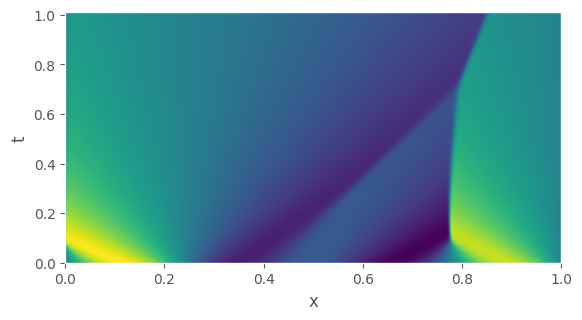

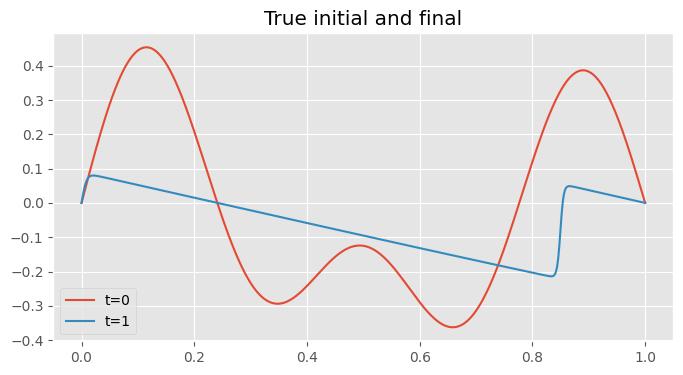

In [3]:
def func_u0(x):
    u0 = -1 *(0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x)))
    return u0


kappa = 0.001
alpha = 2.5


u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

plt.imshow(sols[::-1],aspect = 0.5,extent = [0,1,t_vals[0],t_vals[-1]])
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.show()
plt.figure(figsize=(8,4))
num_fine_grid = 500
plt.title("True initial and final")
grid_points = jnp.linspace(0,1,num_fine_grid)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),label = 't=0')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),label = 't=1')
plt.legend()
plt.show()

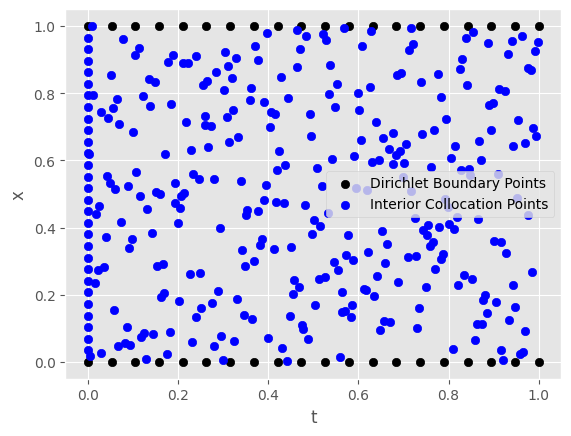

In [5]:
from data_utils import sample_xy_grid_latin

interior,latin_boundary = sample_xy_grid_latin(300,jnp.array([0.,1]),jnp.array([0.,1]),20,30,100)

tx_bdy = latin_boundary[jnp.isin(latin_boundary[:,1],jnp.array([0.,1.]))]
tx_int = jnp.vstack(
    [interior,latin_boundary[
        ~jnp.isin(latin_boundary[:,1],jnp.array([0.,1]))
                  ]]
)
tx_int = tx_int[tx_int[:,0]<1]

plt.scatter(tx_bdy[:,0],tx_bdy[:,1],c = 'black',label = 'Dirichlet Boundary Points')
plt.scatter(tx_int[:,0],tx_int[:,1],c = 'blue',label = "Interior Collocation Points")
plt.legend()
plt.xlabel("t")
plt.ylabel("x")
plt.show()

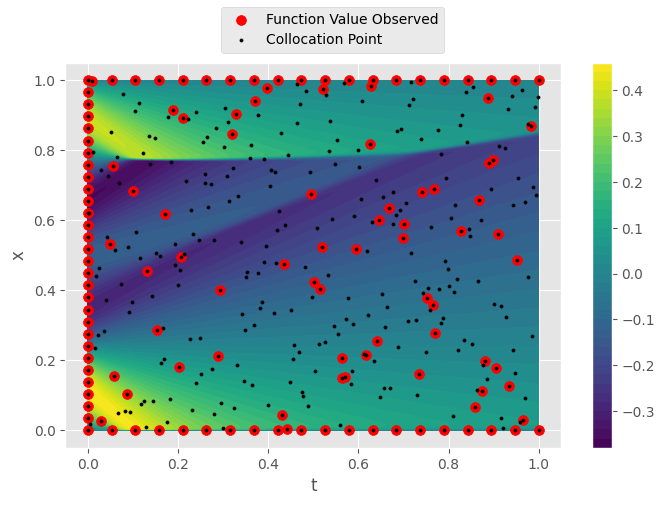

In [6]:

# num_grid_x = 31
# num_grid_t = 26
# tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)
num_points = 40#old value
tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy,
    60,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)

u_true = u_true_function(tx_all)
u_obs = u_true_function(tx_obs)

num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)

In [148]:
# from Kernels import (
#     get_centered_scaled_poly_kernel,
#     get_anisotropic_gaussianRBF,
#     fit_kernel_params,get_rq_kernel,get_gaussianRBF,setup_matern
# )
# from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
# from functools import partial

# u_operators = (eval_k,dx_k,dt_k)
# feature_operators = (eval_k,dx_k,dxx_k)

# from Kernels import log1pexp,inv_log1pexp#,setup_matern

# base_kernel = setup_matern(5)

# def param_base_kernel(x,y,params):
#     d = jnp.sqrt(log1pexp(params))
#     return base_kernel(1.)(d*x,d*y)

# fitted_params,ml_value = fit_kernel_params(param_base_kernel,tx_obs,u_obs,0.5 * jnp.ones(2))
# fitted_params = jnp.minimum(fitted_params,100.)
# ML_lengthscales = log1pexp(fitted_params)

# k_u = partial(param_base_kernel,params = fitted_params)
# print(1/ML_lengthscales)

import Kernels
reload(Kernels)
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

from Kernels import log1pexp,inv_log1pexp

def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2),stepsize = 1e-5,maxiter = 20000)
ML_lengthscales = log1pexp(fitted_params)

k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))
print(1/(jnp.sqrt(ML_lengthscales)))


u_model = CholInducedRKHS(
    tx_all,
    feature_operators,# (eval_k,)
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)

[0.39169436 0.05731475]


In [150]:
if jnp.any(jnp.isnan(u_params_init)):
    raise ValueError



  0%|          | 0/401 [00:00<?, ?it/s]

Iteration 0, loss = 0.163, Jres = 44.47, alpha = 0.08333, improvement_ratio = 0.9485
Iteration 1, loss = 0.09412, Jres = 190.3, alpha = 0.06944, improvement_ratio = 1.034
Iteration 2, loss = 0.07028, Jres = 18.88, alpha = 0.05787, improvement_ratio = 1.039
Iteration 3, loss = 0.05751, Jres = 34.38, alpha = 0.04823, improvement_ratio = 1.025
Iteration 4, loss = 0.04932, Jres = 11.9, alpha = 0.04019, improvement_ratio = 1.021
Iteration 5, loss = 0.04318, Jres = 3.787, alpha = 0.03349, improvement_ratio = 1.02
Iteration 100, loss = 0.003493, Jres = 0.07568, alpha = 8.333e-07, improvement_ratio = 1.002
Iteration 200, loss = 0.003107, Jres = 0.003402, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 0.002986, Jres = 0.00119, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 0.002904, Jres = 0.0005483, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 0.002902883875564978


/tmp/ipykernel_2787374/1333584119.py:30: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


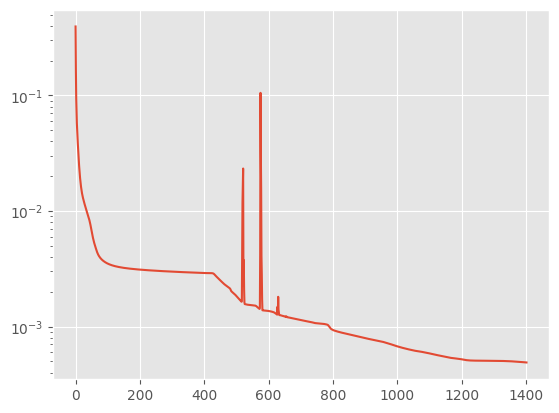

In [152]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

params,convergence_data = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 401,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)

p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,1000,overall_regularization=1e-15,tol = 1e-12)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

Pre Refinement PDE MSE 0.0021755489136630777
Post Refinement PDE MSE 0.0005099252955225966


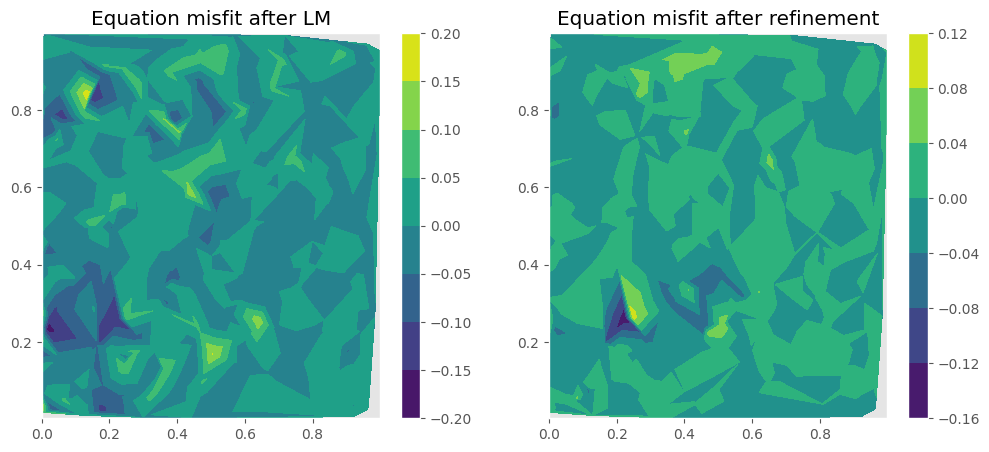

In [153]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.tricontourf(tx_int[:,0],tx_int[:,1],equation_residuals)
plt.grid(None)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Equation misfit after refinement")
plt.tricontourf(tx_int[:,0],tx_int[:,1],equation_residuals_refined)
plt.grid(None)
plt.colorbar()
plt.show()


,NRMSE,NMAE
1 Step,0.350148,0.213717
2 Step,0.817225,0.596405


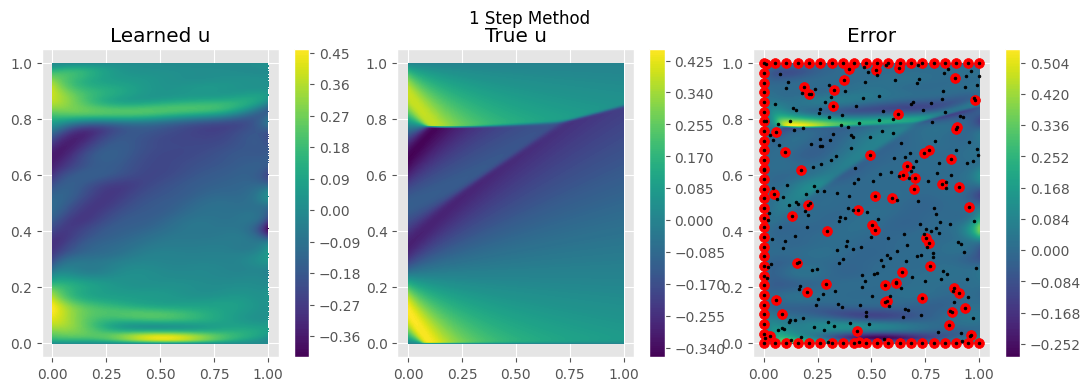

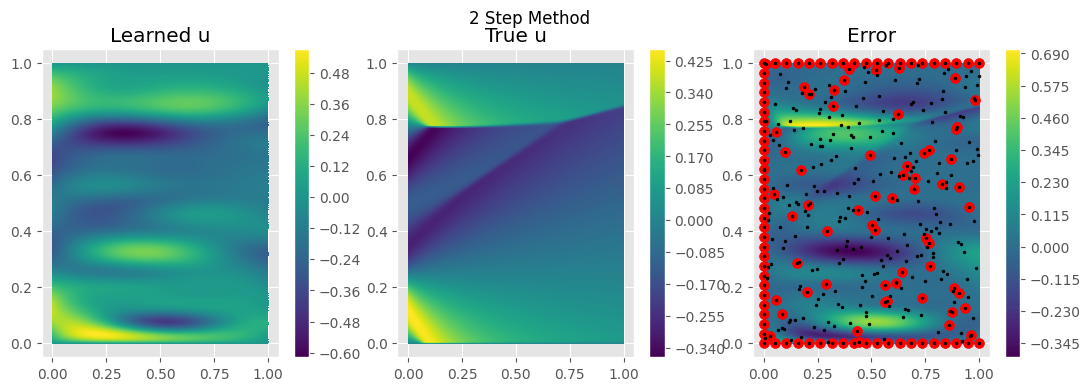

In [154]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

u_sol = params[:u_model.num_params]
P_sol = params[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

In [155]:
tx_fine_int,_ = sample_xy_grid_latin(1500,jnp.array([0.,1]),jnp.array([0.,1]),1,1,seed  = 401)



fine_grid_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
main_features = EqnModel.get_stacked_eqn_features((u_sol,))
P_pred_fine = P_model.predict_new(fine_grid_features,main_features,P_sol)
rhs = EqnModel.get_rhs_op_single(u_model,u_sol,tx_fine_int)

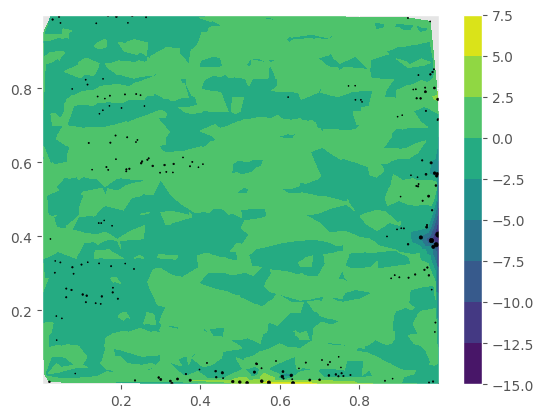

In [157]:
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],rhs - P_pred_fine)
plt.colorbar()
residual = rhs - P_pred_fine
bad_indices = jnp.argsort(jnp.abs(residual))[-200:]
plt.scatter(tx_fine_int[bad_indices,0],tx_fine_int[bad_indices,1],s = jnp.abs(residual[bad_indices]),c='black')

bad_points = tx_fine_int[bad_indices]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.1938, Jres = 118.6, alpha = 0.08333, improvement_ratio = 0.8808
Iteration 1, loss = 0.152, Jres = 444.4, alpha = 0.06944, improvement_ratio = 0.8941
Iteration 2, loss = 0.1205, Jres = 832.0, alpha = 0.05787, improvement_ratio = 1.009
Iteration 3, loss = 0.102, Jres = 437.9, alpha = 0.04823, improvement_ratio = 1.075
Iteration 4, loss = 0.09075, Jres = 117.1, alpha = 0.04019, improvement_ratio = 1.071
Iteration 5, loss = 0.08294, Jres = 3.748, alpha = 0.03349, improvement_ratio = 1.043
Iteration 100, loss = 0.005792, Jres = 0.02668, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 0.005501, Jres = 0.001023, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 0.005395, Jres = 0.0003288, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 0.005329, Jres = 9.79e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 0.005279, Jres = 0.0003011, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/1001 [00:00<?, ?it/s]

Iteration 0, loss = 0.005276737953993053
Converged


/tmp/ipykernel_2787374/1375417564.py:27: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


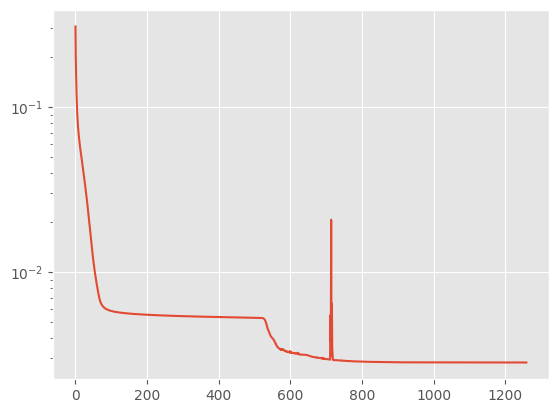

In [158]:
EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (jnp.vstack([tx_int,bad_points]),),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

params_init = jnp.hstack([u_sol,jnp.zeros(len(grid_features_init) + 200)])

params,convergence_data = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)

p_adjusted,refine_convergence_data = adaptive_refine_solution(
    params,EqnModel,1e-4,1001,overall_regularization=1e-15,tol = 1e-12
    )
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

,NRMSE,NMAE
1 Step,0.289605,0.176726
2 Step,0.817225,0.596405


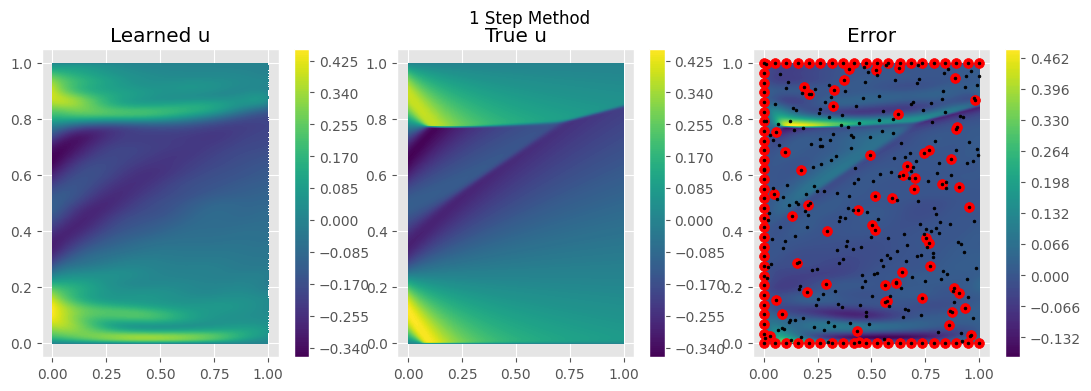

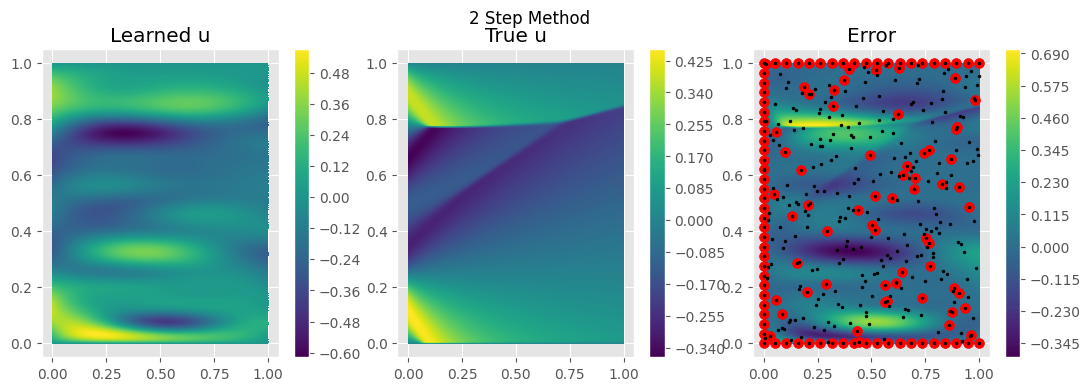

In [159]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

u_sol = params[:u_model.num_params]
P_sol = params[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

In [37]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interpolant.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interpolant.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interpolant.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = jnp.linalg.solve(K+1e-8*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = EqnModel.get_single_eqn_features(u_model,u_params_init,tx_fine_int)
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

compute_results(
    ut_true,
    {
        "1 Step Model Features":preds_ut_model_features,
        "1 Step True Features":preds_ut_true_features,
        "2 Step Model Features": P_preds_init_model_features_init,
        "2 Step True Features":P_preds_init_true_features,
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
)

,NRMSE,NMAE
1 Step Model Features,0.981474,0.922558
1 Step True Features,20145.326967,1293.219517
2 Step Model Features,0.999130,1.034450
2 Step True Features,4320.647554,274.278231


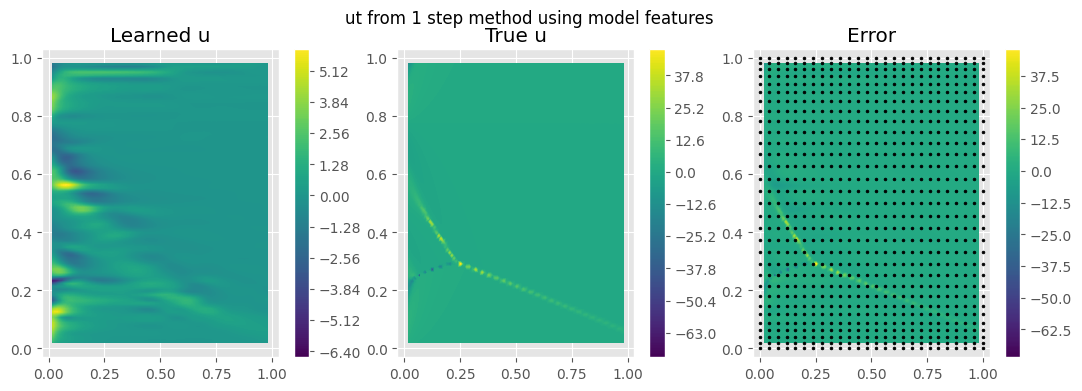

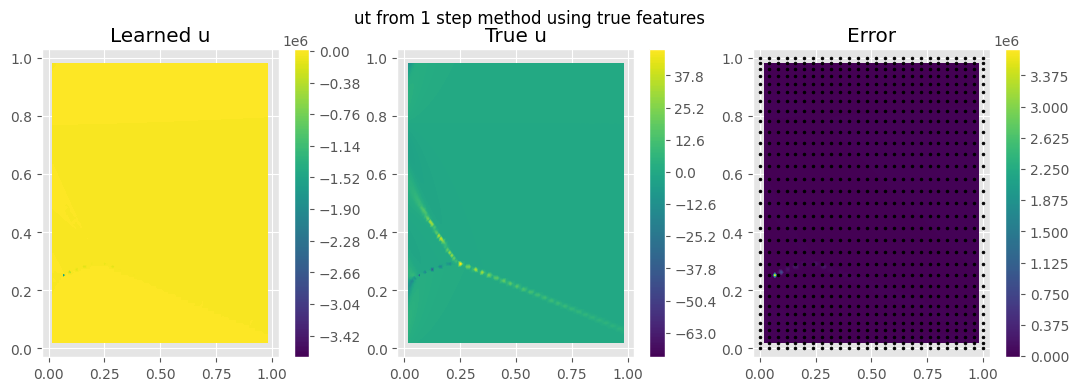

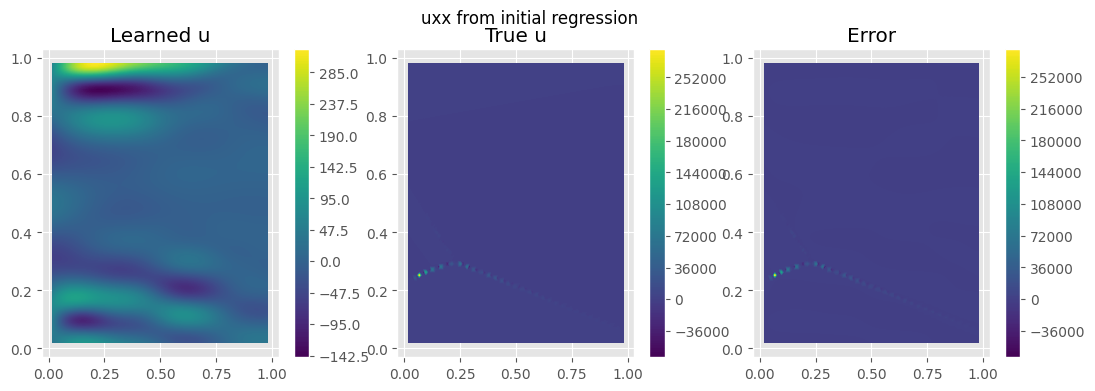

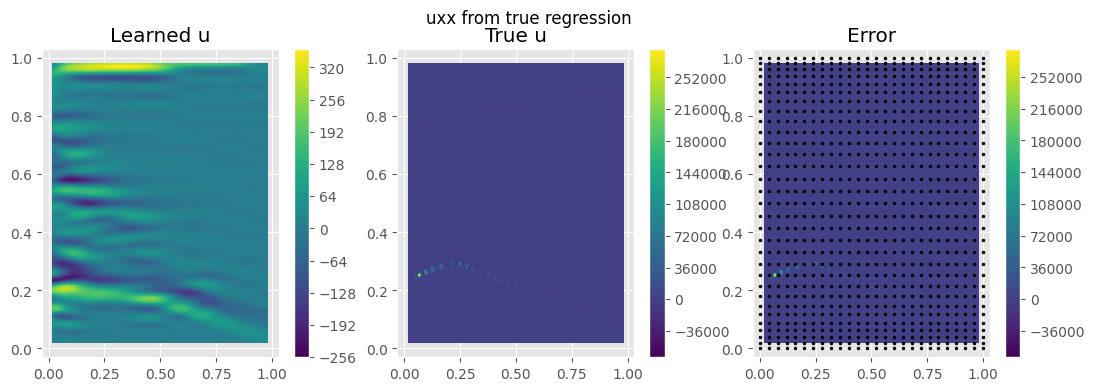

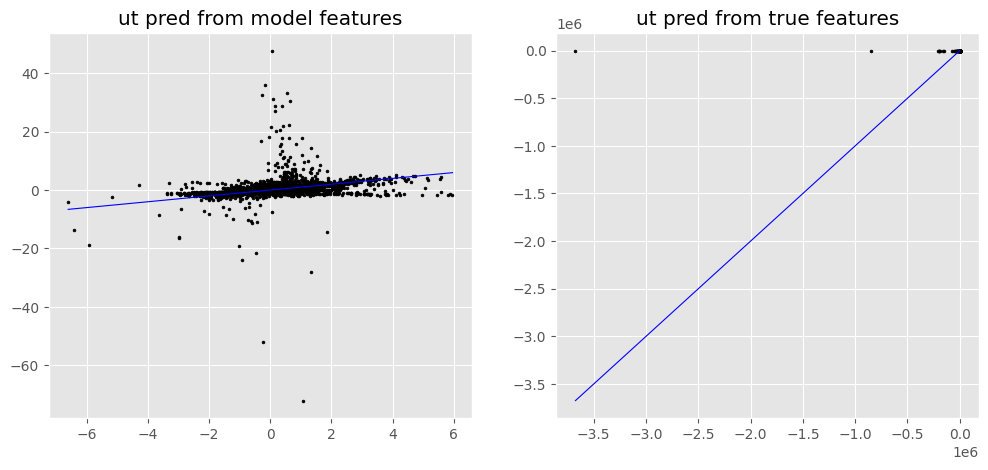

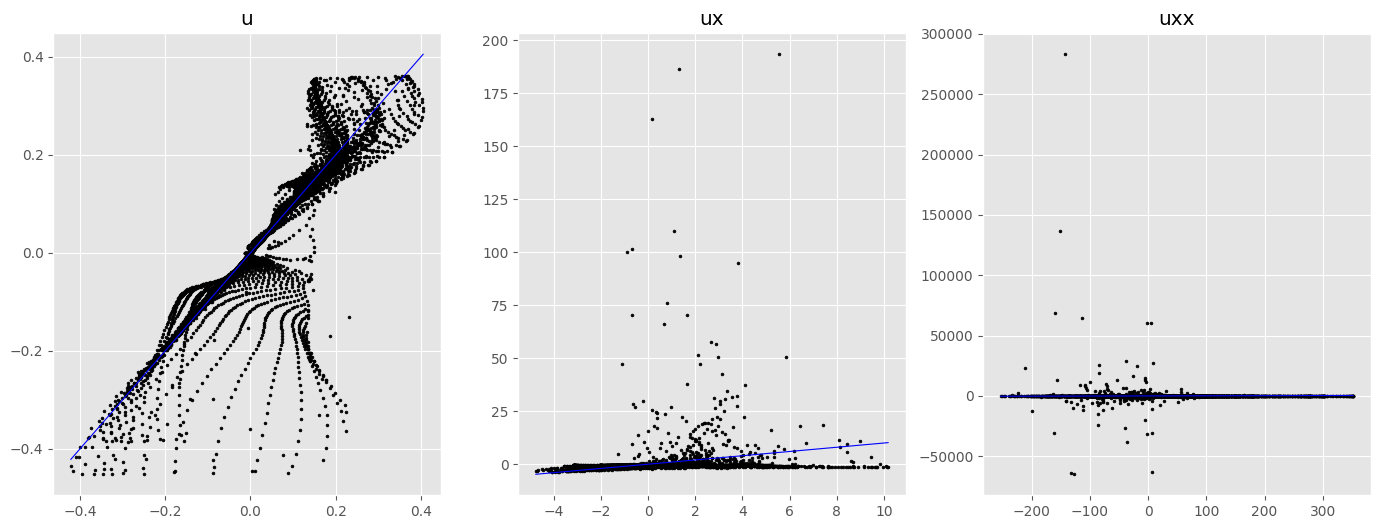

In [38]:
from plotting import compare_values,plot_compare_error_values

plot_compare_error_values(
    tx_fine_int,tx_all,None,preds_ut_model_features,ut_true,title = "ut from 1 step method using model features"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,preds_ut_true_features,ut_true,title = "ut from 1 step method using true features"
)

plot_compare_error_values(
    tx_fine_int,None,None,init_P_features_fine[:,4],uxx_true,title = "uxx from initial regression"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,model_features[:,4],uxx_true,title = "uxx from true regression"
)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,2],true_features[:,2])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,3],true_features[:,3])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,4],true_features[:,4])
plt.show()


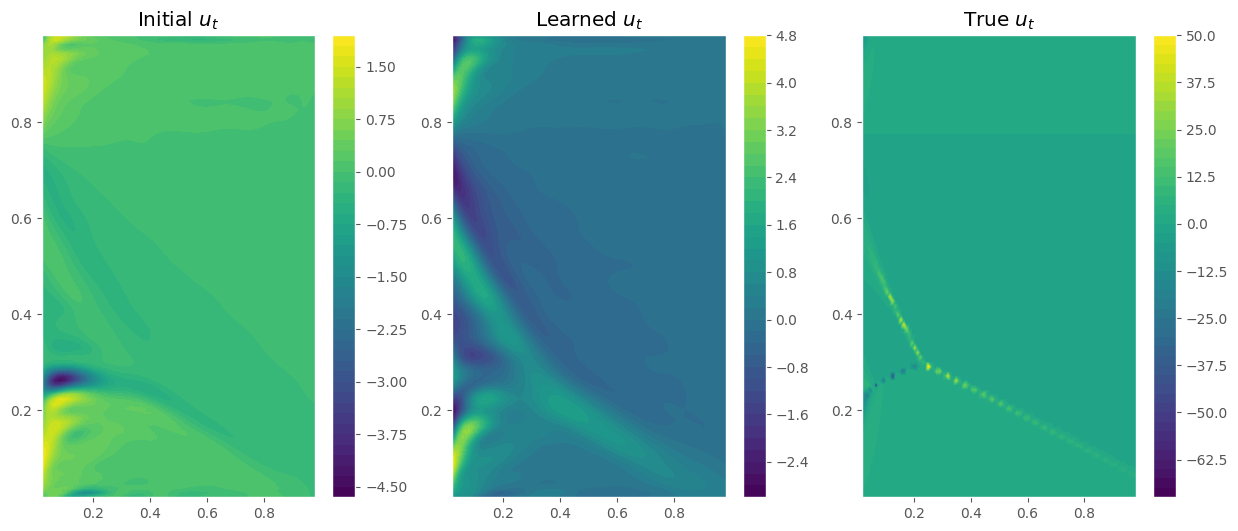

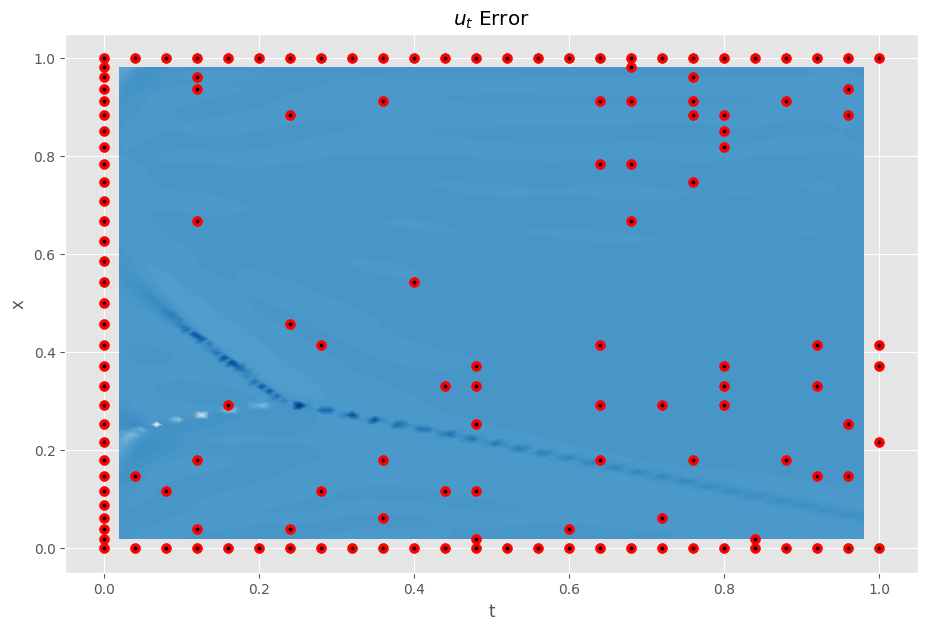

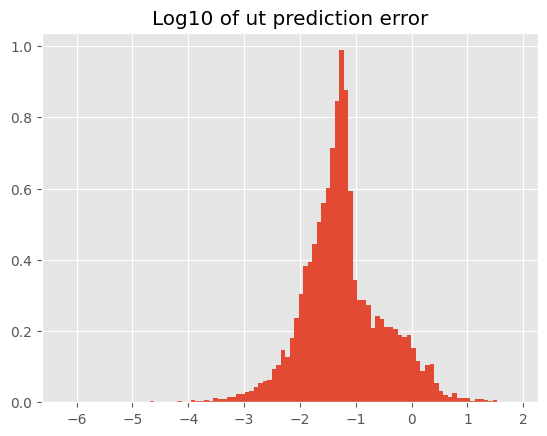

In [62]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

  0%|          | 0/10099 [00:00<?, ?it/s]

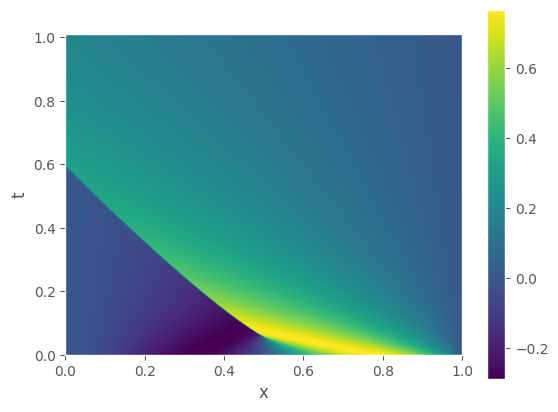

In [63]:
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0

new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

plt.imshow(sols_new[::-1],aspect = 0.8,extent = [0,1,t_vals[0],t_vals[-1]])
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()

In [64]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol
tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

new_obs = new_u_true_function(tx_init_bdy)


class PdeModel():
    datafit_weight = 50.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return jnp.hstack([tx_int,grid_features])
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators((dt_k,),tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model.kmat+1e-5 * diagpart(u_model.kmat)

In [65]:
new_u_init = 0*u_sol

u_params_pde,pde_convergence_data = LevenbergMarquadtMinimize(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)
u_pde_adj,pde_refine_conv_data = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 1.608, Jres = 172.8, alpha = 0.04167, improvement_ratio = 0.9769
Iteration 1, loss = 0.3078, Jres = 7.935, alpha = 0.03472, improvement_ratio = 0.8692
Iteration 2, loss = 0.1414, Jres = 1.669, alpha = 0.02894, improvement_ratio = 0.9147
Iteration 3, loss = 0.1303, Jres = 0.1626, alpha = 0.02411, improvement_ratio = 1.003
Iteration 4, loss = 0.1259, Jres = 0.03763, alpha = 0.02009, improvement_ratio = 1.198
Iteration 5, loss = 0.1228, Jres = 0.03998, alpha = 0.01674, improvement_ratio = 1.244
Iteration 10, loss = 0.1131, Jres = 0.0252, alpha = 0.006729, improvement_ratio = 1.202
Iteration 20, loss = 0.1043, Jres = 0.0111, alpha = 0.001087, improvement_ratio = 1.097
Iteration 30, loss = 0.09939, Jres = 0.006783, alpha = 0.0001755, improvement_ratio = 1.042
Iteration 40, loss = 0.09455, Jres = 0.004705, alpha = 2.835e-05, improvement_ratio = 1.032
Iteration 50, loss = 0.09129, Jres = 0.001026, alpha = 4.579e-06, improvement_ratio = 1.001
Iteration 60, loss = 0.08612, J

  0%|          | 0/150 [00:00<?, ?it/s]

Sup norm error:  0.7672595474654318
NRMSE  0.5419016189035322


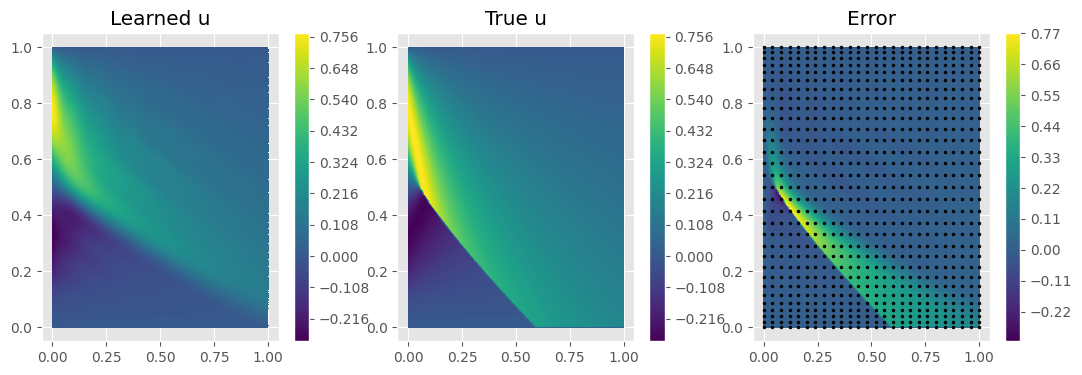

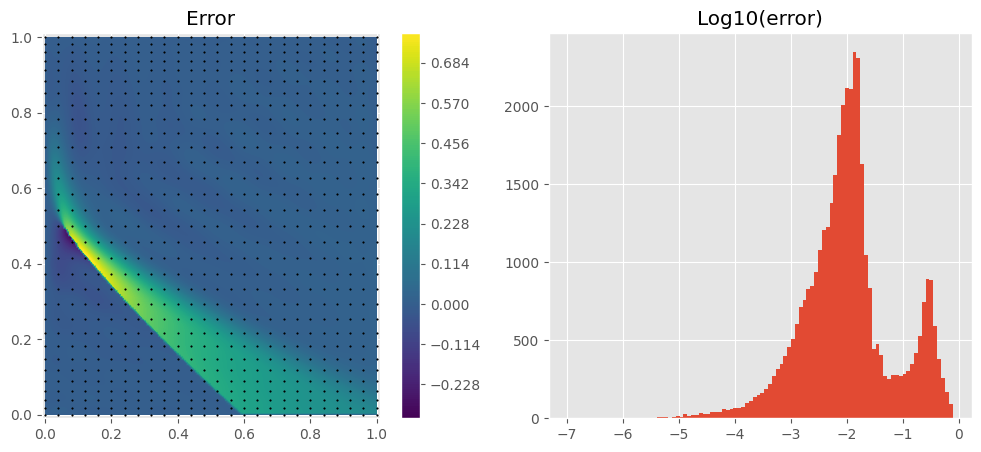

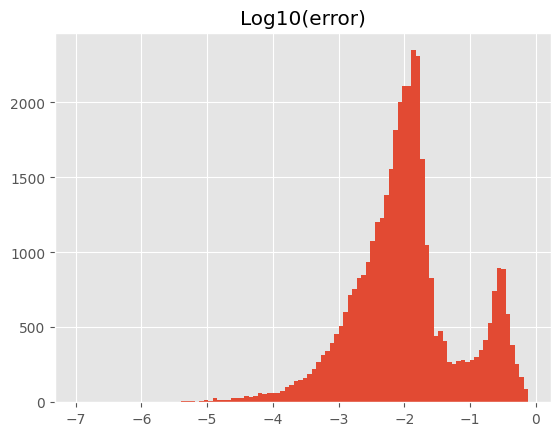

In [66]:
from plotting import plot_compare_error
new_u_eval_fine = u_model.point_evaluate(tx_grid_fine,u_pde_adj)
new_u_true_fine = new_u_true_function(tx_grid_fine)

print("Sup norm error: ",jnp.max(jnp.abs(new_u_true_fine-new_u_eval_fine)))
print("NRMSE ",get_nrmse(new_u_true_fine,new_u_eval_fine))

plot_compare_error(
    tx_grid_fine,
    tx_all,
    None,
    lambda x:u_model.point_evaluate(x,u_pde_adj),
    new_u_true_function
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],s = 1,c='black')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.title("Error")
plt.subplot(1,2,2)
plt.title("Log10(error)")
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()

plt.title("Log10(error)")
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()